In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import tensorflow as tf
import tensorflow_addons as tfa

from matplotlib.colors import LogNorm
from mpl_toolkits.mplot3d import Axes3D
from scipy import stats
from copy import deepcopy
from sklearn.model_selection import train_test_split
#from sklearn.preprocessing import MinMaxScaler #, StandardScaler
from multiprocessing import Process, Pool

%load_ext autoreload
%autoreload 1

from freedom.toy_model import advanced_toy_3D, NNs
%aimport freedom.toy_model.advanced_toy_3D
%aimport freedom.toy_model.NNs

In [2]:
params = {'legend.fontsize': 17,
          'figure.figsize': (15, 9.3),
          'axes.labelsize': 24,
          'axes.titlesize': 24,
          'xtick.labelsize': 22,
          'ytick.labelsize': 22}
plt.rcParams.update(params)

par_names = ['x', 'y', 'z', 't', 'azi', 'zen', 'Ecscd', 'Etrck']
data_path = '../../../freedom/resources/toy_data/'
plot_path = '../../../plots/toy_model/'

In [3]:
#Build DeepCore-like detector
detectors = np.vstack([[3.1,7.2,4.2,10.7,11.3,5.7,-1.0,-1.1], [-7.3,-6.7,3.5,2.7,-6.0,-10.5,-8.0,0.7], np.ones(8)]).T
detectors = np.repeat(detectors, 25, axis=0)
detectors[:, 2] = np.tile(np.linspace(-17, 17, 25), 8)
toy_experiment = advanced_toy_3D.advanced_toy_experiment(detectors=detectors, time_dist=advanced_toy_3D.pandel)

Text(0, 0.5, 'time pdf')

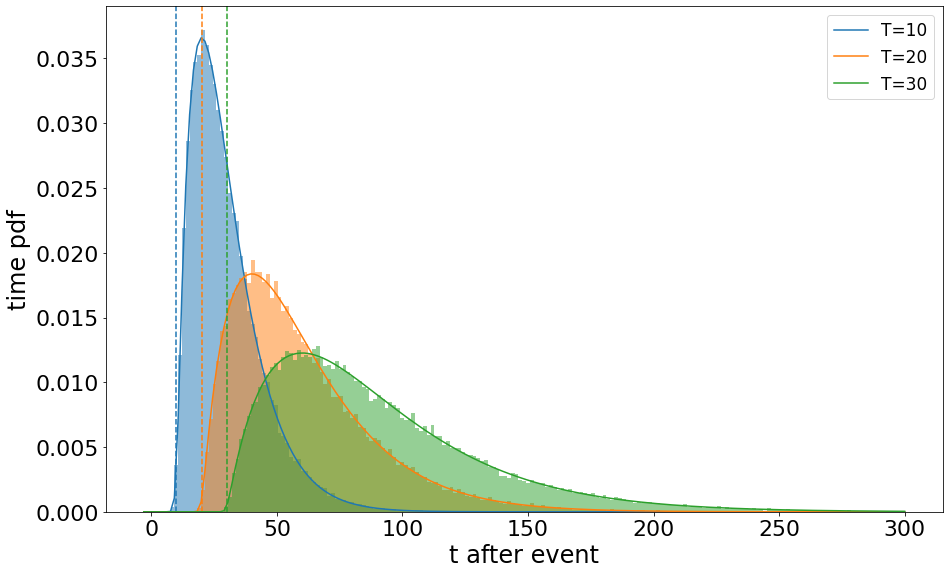

In [4]:
# test time distribution
p1 = advanced_toy_3D.pandel(10)
p2 = advanced_toy_3D.pandel(20)
p3 = advanced_toy_3D.pandel(30)

x = np.linspace(-3, 300, 200)
plt.plot(x, p1.pdf(x), label='T=10')
plt.hist(p1.rvs(50000), x, density=True, color='Tab:blue', alpha=0.5)
plt.axvline(10, color='Tab:blue', linestyle='--')
plt.plot(x, p2.pdf(x), label='T=20')
plt.hist(p2.rvs(50000), x, density=True, color='Tab:orange', alpha=0.5)
plt.axvline(20, color='Tab:orange', linestyle='--')
plt.plot(x, p3.pdf(x), label='T=30')
plt.hist(p3.rvs(50000), x, density=True, color='Tab:green', alpha=0.5)
plt.axvline(30, color='Tab:green', linestyle='--')

plt.legend()
plt.xlabel('t after event')
plt.ylabel('time pdf')
#plt.savefig('../../../plots/toy_model/time_pdf', bbox_inches='tight')

## Create events

In [ ]:
N = 10000

if 'events' in locals():
    events2, Truth2 = toy_experiment.generate_events(N)
    events = np.concatenate([events, events2])
    Truth = np.concatenate([Truth, Truth2])
else:
    events, Truth = toy_experiment.generate_events(N)

#np.save('../../../freedom/resources/toy_data/toy_events_3D', events)
#np.save('../../../freedom/resources/toy_data/toy_truth_3D', Truth)

## Train NNs

In [ ]:
events = np.load('../../../freedom/resources/toy_data/toy_events_3D.npy', allow_pickle=True)#[:100000]
Truth = np.load('../../../freedom/resources/toy_data/toy_truth_3D.npy', allow_pickle=True)#[:100000]

In [ ]:
strategy = tf.distribute.MirroredStrategy()
nGPUs = strategy.num_replicas_in_sync

hitNet

In [ ]:
x, t = NNs.get_hit_data(events, Truth)
x_train, x_test, t_train, t_test = train_test_split(x, t, test_size=0.1, random_state=42)

d_train = NNs.DataGenerator(x_train, t_train, batch_size=4096*nGPUs)
d_valid = NNs.DataGenerator(x_test, t_test, batch_size=4096*nGPUs)

In [ ]:
optimizer = tf.keras.optimizers.Adam(1e-3)
with strategy.scope():
    hmodel = NNs.get_hmodel(x_shape=4, t_shape=8, trafo=NNs.hit_trafo_3D, activation=tfa.activations.mish)
    hmodel.compile(loss='binary_crossentropy', optimizer=optimizer)
hmodel.summary()

In [ ]:
hist = hmodel.fit(d_train, epochs=10, verbose=1, validation_data=d_valid)

In [ ]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.yscale('log')

In [ ]:
inp, lab = d_valid.__getitem__(0)
pred = hmodel.predict(inp, batch_size=nGPUs*4096).flatten()
plt.hist(pred[lab==0], 100, histtype='step')
plt.hist(pred[lab==1], 100, histtype='step');
plt.yscale('log')

In [ ]:
hmodel.layers[-1].activation = tf.keras.activations.linear
hmodel.compile()
#hmodel.save('../../../freedom/resources/models/toy/hitNet_3D.hdf5')

chargeNet

In [ ]:
x, t = NNs.get_charge_data(events, Truth)
x_train, x_test, t_train, t_test = train_test_split(x, t, test_size=0.1, random_state=42)

d_train = NNs.DataGenerator(x_train, t_train, batch_size=2048*nGPUs)
d_valid = NNs.DataGenerator(x_test, t_test, batch_size=2048*nGPUs)

In [ ]:
optimizer = tf.keras.optimizers.Adam(2e-3)
with strategy.scope():
    cmodel = NNs.get_cmodel(x_shape=2, t_shape=8, trafo=NNs.charge_trafo_3D, activation=tfa.activations.mish)
    cmodel.compile(loss='binary_crossentropy', optimizer=optimizer)
cmodel.summary()

In [ ]:
hist = cmodel.fit(d_train, epochs=50, verbose=1, validation_data=d_valid)

In [ ]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.yscale('log')

In [ ]:
inp, lab = d_valid.__getitem__(0)
pred = cmodel.predict(inp, batch_size=nGPUs*4096).flatten()
plt.hist(pred[lab==0], 100, histtype='step')
plt.hist(pred[lab==1], 100, histtype='step');
plt.yscale('log')

In [ ]:
cmodel.layers[-1].activation = tf.keras.activations.linear
cmodel.compile()
cmodel.save('../../../freedom/resources/models/toy/chargeNet_3D.hdf5')

checks

In [6]:
x = np.zeros(400).reshape((100,4))
o = np.ones(100)
t = np.stack([o, o, o, np.linspace(-15,1,100), 0*o, 0*o, 10*o, 0*o]).T
pred = -hmodel.predict([x, t])

true = []
for T in np.linspace(-15,1,100):
    true.append(-toy_experiment.hit_term(np.array([np.append(x[0], 0)]), [1,1,1], T, [0, 0], 10, 0))
true = np.array(true)

Text(0, 0.5, 'PDF')

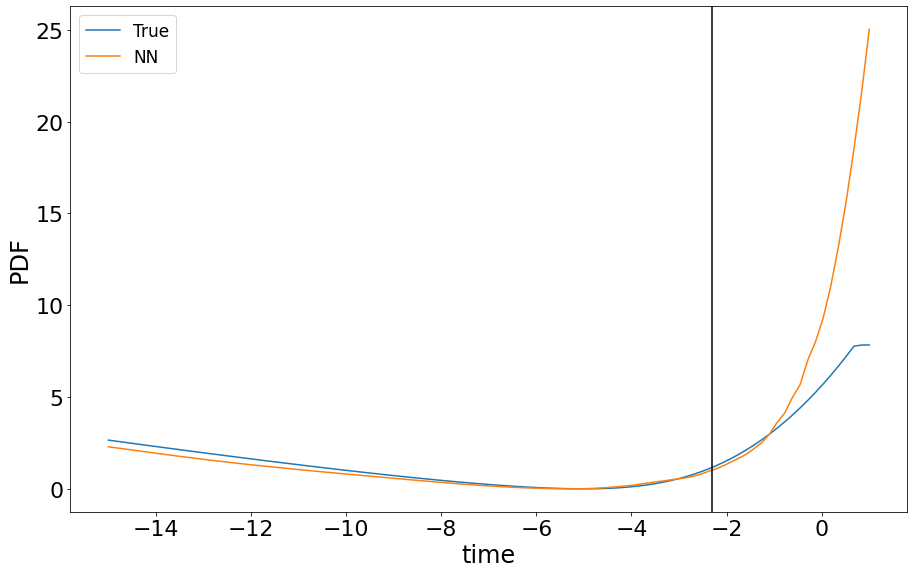

In [7]:
plt.plot(np.linspace(-15,1,100), true-np.min(true), label='True')
plt.plot(np.linspace(-15,1,100), pred-np.min(pred), label='NN')
#plt.plot(np.linspace(-15,1,100), np.exp(-true)/np.sum(np.exp(-true)), label='True')
#plt.plot(np.linspace(-15,1,100), np.exp(-pred)/np.sum(np.exp(-pred)), label='NN')
plt.axvline(-np.sqrt(3)*1.33, color='black')
plt.legend()
plt.xlabel('time')
plt.ylabel('PDF') #plt.ylabel('dLLH')
#plt.savefig('../../../plots/toy_model/LLH_scans/hitnet_test_pdf', bbox_inches='tight')

In [8]:
x = 10*np.ones(200).reshape((100,2))
o = np.ones(100)
t = np.stack([o, o, o, 0*o, 0*o, 0*o, np.linspace(1,30,100), 0*o]).T
pred = -cmodel.predict([x, t])

true = []
for E in np.linspace(1,30,100):
    true.append(-toy_experiment.charge_term(x[0], [1,1,1], [0,0], E, 0))

Text(0, 0.5, 'dLLH')

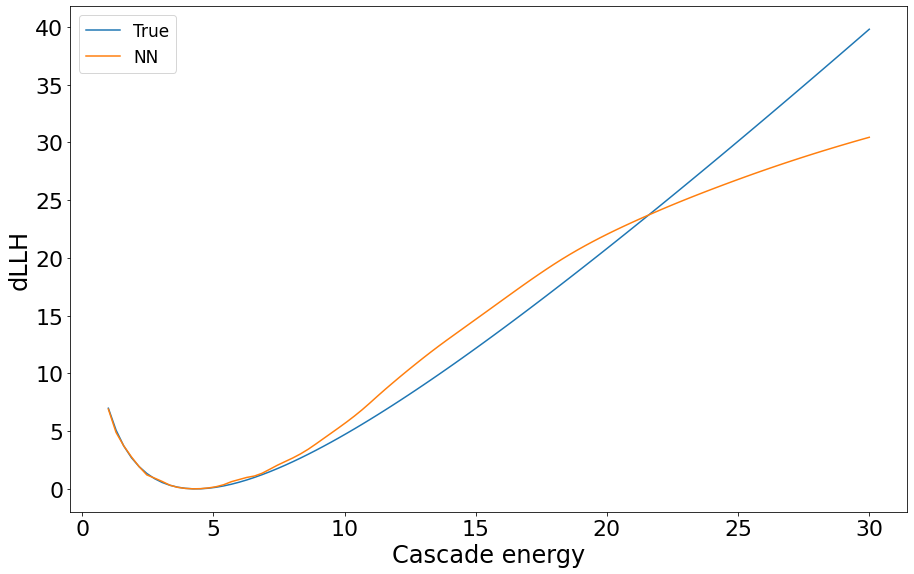

In [9]:
plt.plot(np.linspace(1,30,100), np.array(true)-np.min(true), label='True')
plt.plot(np.linspace(1,30,100), pred-np.min(pred), label='NN')
plt.legend()
plt.xlabel('Cascade energy')
plt.ylabel('dLLH')
#plt.savefig('../../../plots/toy_model/LLH_scans/chargenet_test', bbox_inches='tight')

Dataset?

In [ ]:
dataset_tf = tf.data.Dataset.from_generator(
    lambda: (s for s in d_train),
    output_types=((tf.int64, tf.float64), tf.int64), 
    #output_shapes=([32,256,256,3], [32,5])
)

dataset_tf_val = tf.data.Dataset.from_generator(
    lambda: (s for s in d_valid),
    output_types=((tf.int64, tf.float64), tf.int64), 
    #output_shapes=([32,256,256,3], [32,5])
)

In [ ]:
dataset_tf = dataset_tf.prefetch(len(d_train))
dataset_tf_val = dataset_tf.prefetch(len(d_valid))

In [ ]:
hist = cmodel.fit(dataset_tf, epochs=15, verbose=1, validation_data=dataset_tf_val)

## Test event

In [14]:
# generate one test event

pos_src = np.random.rand(3) * np.array([14,16,32]) + np.array([-2,-12,-16])
Ecscd_src, Etrck_src = 19*np.random.rand()+1, 20*np.random.rand()
ang_src = np.random.rand(2) * np.array([2,1])*np.pi
test_event = toy_experiment.generate_event(pos_src, ang_src, Ecscd_src, Etrck_src)
truth = np.array([pos_src[0], pos_src[1], pos_src[2], 0, ang_src[0], ang_src[1], Ecscd_src, Etrck_src])

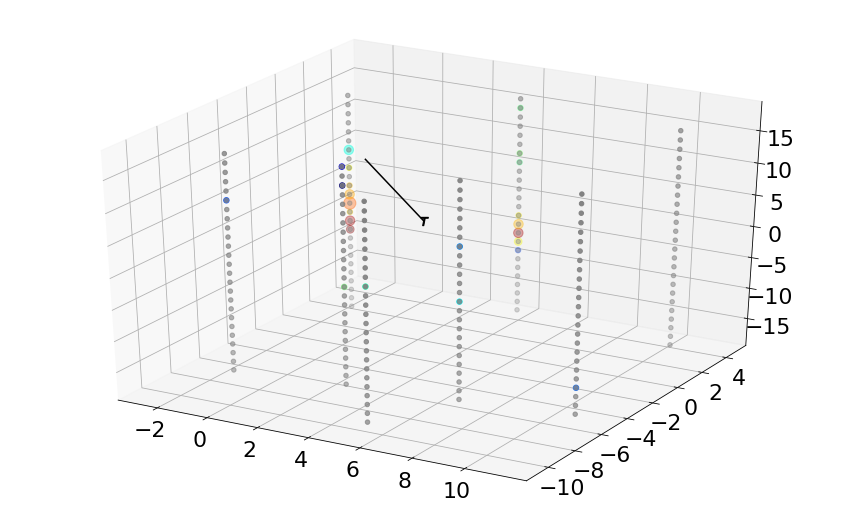

In [15]:
u, idx, c = np.unique(test_event[1][:,4], return_counts=True, return_index=True)
ts, i = [], 0
for C in c:
    ts.append(np.log(np.median(test_event[1][i:i+C,0])))
    i += C

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(toy_experiment.detectors[0], toy_experiment.detectors[1], toy_experiment.detectors[2], color='grey')
ax.scatter(test_event[1][idx, 1], test_event[1][idx, 2], test_event[1][idx, 3], s=30*c, c=ts, cmap='jet_r')
ax.scatter(truth[0], truth[1], truth[2], color='black', marker='$T$', s=70)
ax.plot([truth[0], truth[0]-Etrck_src/3*np.sin(truth[5])*np.cos(truth[4])], 
        [truth[1], truth[1]-Etrck_src/3*np.sin(truth[5])*np.sin(truth[4])], 
        [truth[2], truth[2]-Etrck_src/3*np.cos(truth[5])], color='black')
#ax.view_init(elev=0., azim=0.)
#plt.savefig('../../../plots/toy_model/test_event2', bbox_inches='tight')

#### LLH scans

In [5]:
loc = '../../../freedom/resources/models/toy/'
cmodel = tf.keras.models.load_model(loc+'chargeNet_3D.hdf5', custom_objects={'charge_trafo_3D':NNs.charge_trafo_3D})
hmodel = tf.keras.models.load_model(loc+'hitNet_3D.hdf5', custom_objects={'hit_trafo_3D':NNs.hit_trafo_3D})

In [16]:
bounds = np.array([[-2,12], [-12,4], [-18,18], [-30,30], [0, 2*np.pi], [0, np.pi], [1,30], [0,30]])

def LLH(X, event, only_c=False, only_h=False, fix=[None], bounds=bounds):
    #X: hypo_x, hypo_y, hypo_t, hypo_N_src, hypo_ang
    assert only_c + only_h < 2
    
    if fix[0] != None:
        X = np.insert(X, fix[0], fix[1])
        
    if ~np.alltrue(np.logical_and(bounds[:,0] <= X, X <= bounds[:,1]), axis=-1):
        return 1e9
    
    pos = np.array([X[0], X[1], X[2]])
    angs = np.array([X[4], X[5]])
    c_term = -toy_experiment.charge_term(event[0], pos, angs, X[6], X[7])
    h_term = -toy_experiment.hit_term(event[1], pos, X[3], angs, X[6], X[7])
    
    if only_c: return c_term
    if only_h: return h_term
    return c_term + h_term

def LLH_NN(X, event, chargeNet=None, hitNet=None, fix=[None], bounds=bounds):
    #X: hypo_x, hypo_y, hypo_t, hypo_N_src, hypo_ang
    if fix[0] != None:
        X = np.insert(X, fix[0], fix[1])
        
    if ~np.alltrue(np.logical_and(bounds[:,0] <= X, X <= bounds[:,1]), axis=-1):
        return 1e9
    
    c_term = 0
    if chargeNet != None:
        x, t = event[0].reshape((1,2)), np.array([X])
        c_term = -chargeNet.predict([x, t])[0, 0]
    h_term = 0
    if hitNet != None and len(event[1]) > 0:
        x, t = event[1][:,:4], np.repeat([X], len(event[1]), axis=0)
        h_term = -np.sum(hitNet.predict([x, t]))
    
    return c_term + h_term

In [17]:
# 1d LLH space
point, point2 = truth, truth

X = np.linspace(max(point[0]-2, -2), min(point[0]+2, 12), 100)
Y = np.linspace(max(point[1]-2, -12), min(point[1]+2, 4), 100)
Z = np.linspace(max(point[2]-3, -18), min(point[2]+3, 18), 100)
T = np.linspace(point[3]-10, point[3]+10, 100)
AZI, ZEN = np.linspace(0, 2*np.pi, 100), np.linspace(0, np.pi, 100)
ECSCD, ETRCK = np.linspace(max(point[6]-7,1), point[6]+7, 100), np.linspace(max(point[7]-7,0), point[7]+7, 100)
ranges = [X, Y, Z, T, AZI, ZEN, ECSCD, ETRCK]

llhs, llhs_nn = [], []
for i in range(len(ranges)):
    llh, llh_nn = [], []
    p, p2 = deepcopy(point), deepcopy(point2)
    for idx in np.ndindex(ranges[i].shape):
        p[i], p2[i] = ranges[i][idx], ranges[i][idx]
        llh.append(LLH(p, test_event)) #, only_h=True
        llhs_nn = np.append(llhs_nn, p2)
    llhs.append(llh-np.min(llh))
llhs = np.array(llhs)

#NN
c_ts = llhs_nn.reshape((800,8))
c_xs = np.tile(test_event[0], len(c_ts)).reshape(len(c_ts), 2)
h_ts = np.repeat(c_ts, test_event[1].shape[0], axis=0)
h_xs = np.tile(test_event[1][:, :4], (len(c_ts),1))

nn_c = -cmodel.predict([c_xs, c_ts], batch_size=4096).reshape(llhs.shape)
nn_h = -hmodel.predict([h_xs, h_ts], batch_size=4096).reshape((len(c_ts), test_event[1].shape[0]))
nn_h = np.sum(nn_h, axis=1).reshape(llhs.shape)
llhs_nn = nn_c + nn_h
for l in llhs_nn:
    l -= np.min(l)

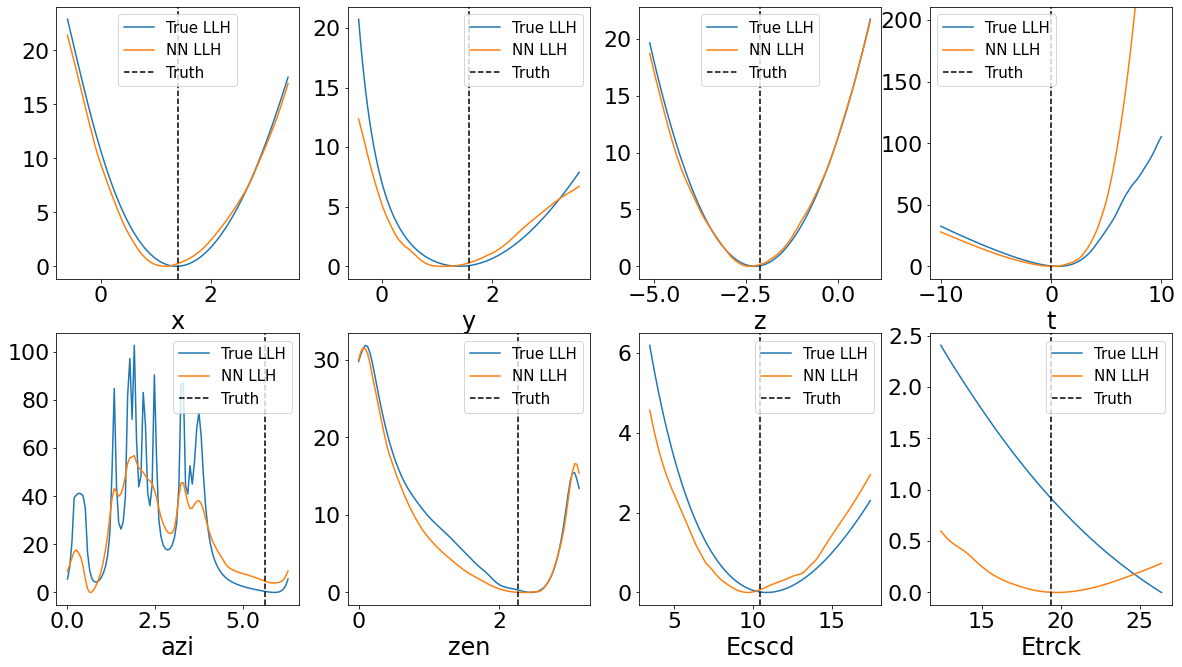

In [18]:
plt.figure(figsize=(20, 11))
for i in range(8):
    plt.subplot(2,4,i+1)
    plt.plot(ranges[i], llhs[i], label='True LLH')
    plt.plot(ranges[i], llhs_nn[i], label='NN LLH')
    plt.axvline(truth[i], color='black', linestyle='--', label='Truth')
    
    if i == 3: plt.ylim(-10, 2*max(llhs[i]))
    plt.legend(fontsize=15)
    plt.xlabel(par_names[i])
    #plt.ylim(0,10)
#plt.savefig('../../../plots/toy_model/LLH_scans/llh_scans_event2', bbox_inches='tight')

In [19]:
# Grid scan
X = np.linspace(-2, 12, 70)
Y = np.linspace(-12, 4, 70)
x, y = np.meshgrid(X, Y)

g = {}
g['hit_terms'] = np.empty(x.shape)
g['charge_terms'] = np.empty(x.shape)

for idx in np.ndindex(x.shape):
    hypo_pos =  np.array([x[idx], y[idx], truth[2]])
    hypo_t = truth[3]
    g['hit_terms'][idx] = -toy_experiment.hit_term(test_event[1], hypo_pos, hypo_t, ang_src, Ecscd_src, Etrck_src)
    g['charge_terms'][idx] = -toy_experiment.charge_term(test_event[0], hypo_pos, ang_src, Ecscd_src, Etrck_src)

g['total_llh'] = g['hit_terms'] + g['charge_terms']
g['total_llh'] -= np.min(g['total_llh'])

#NN
o = np.ones(np.prod(x.shape))
c_ts = np.vstack([x.flatten(), y.flatten(), o*truth[2], o*0, o*ang_src[0], o*ang_src[1], o*Ecscd_src, o*Etrck_src]).T
c_xs = np.tile(test_event[0], np.prod(x.shape)).reshape(np.prod(x.shape), 2)
h_ts = np.repeat(c_ts, test_event[1].shape[0], axis=0)
h_xs = np.tile(test_event[1][:, :4], (np.prod(x.shape),1))

g_nn_c = -cmodel.predict([c_xs, c_ts], batch_size=4096).reshape(g['total_llh'].shape)
g_nn_h = -hmodel.predict([h_xs, h_ts], batch_size=4096).reshape((np.prod(x.shape), test_event[1].shape[0]))
g_nn_h = np.sum(g_nn_h, axis=1).reshape(g['total_llh'].shape)
g_nn = g_nn_c + g_nn_h
g_nn -= np.min(g_nn)

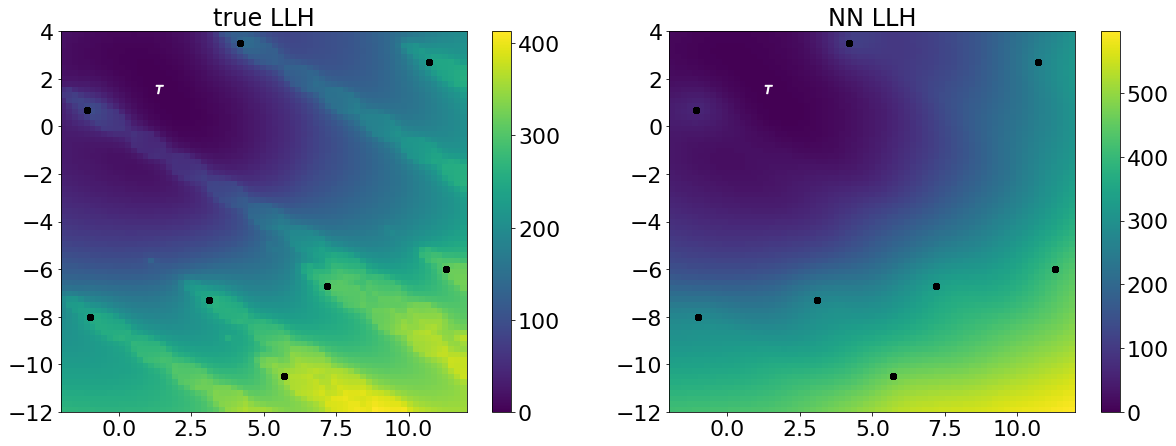

In [20]:
#plot 2d LLH space
plt.figure(figsize=(20,7))
#plt.suptitle('At bf', y=0.98, size=23)

plt.subplot(121)
plt.pcolormesh(X, Y, g['total_llh']) #, vmax=500
plt.colorbar()
plt.title('true LLH')
plt.scatter(pos_src[0], pos_src[1], color='white', marker='$T$', s=70)
plt.scatter(toy_experiment.detectors[0], toy_experiment.detectors[1], color='black')

plt.subplot(122)
plt.pcolormesh(X, Y, g_nn) #, vmax=500
plt.colorbar()
plt.title('NN LLH')
plt.scatter(pos_src[0], pos_src[1], color='white', marker='$T$', s=70)
plt.scatter(toy_experiment.detectors[0], toy_experiment.detectors[1], color='black')

#plt.savefig('../../../plots/toy_model/LLH_scans/xy_llh_scan_event2', bbox_inches='tight')